# First attempt to identify highly correlated properties of the same pos

The purpose of this script is to help describe how a certain category is distributed. The idea is that if certain properties of elements in a category correlate a lot and others not at all but they are properties of the same category as it is currently defined then maybe this category needs to be cut differently, and subcategorised further.

In [2]:
# get the output of grex - in this case we looked at all the nodes and tried to find predictors of adjectives

import pandas as pd
import numpy as np
import json

data = json.loads(open('/Users/madalina/Documents/M2TAL/stage/grex/grex2/all_adjectives_french.json').read())
rules_df = pd.json_normalize(data['rules'])
print(rules_df.head())

                        pattern  n_pattern_occurence  \
0   node:X:own:rel_shallow=amod                17690   
1  node:X:parent:position=after               178587   
2        node:X:own:Gender=Masc                82970   
3  node:X:child:rel_shallow=cop                 4906   
4          node:X:prev:upos=ADV                11357   

   n_pattern_positive_occurence decision  alpha     value   coverage  \
0                         17666      yes  0.052  0.074925  84.131822   
1                          5563       no  0.007 -0.091400  58.738021   
2                         11095      yes  0.004  0.114463  52.838366   
3                          1398      yes  0.004  0.284475   6.657777   
4                          1618      yes  0.002  0.377514   7.705496   

   precision         delta   g-statistic  p-value  cramers_phi  
0  99.864330  16488.897768  95386.143350      0.0     2.322088  
1  96.884992  -6320.276217   4432.629318      0.0     0.157545  
2  13.372303   5574.131024   4750.6

coverage = out of all the adjectives, how many have this pattern

precision = out of all of the occurrences of this pattern, how many are adjectives

In [3]:
import grewpy
from grewpy import Corpus, CorpusDraft, Request

connected to port: 51220


In [ ]:
treebank_path = "/Users/madalina/Documents/M1TAL/stage-SK/Treebanks/UD_French-GSD-master/fr_gsd-ud-train.conllu"
grewpy.set_config("ud")
corpus = Corpus(treebank_path)
print(type(corpus))

<class 'grewpy.corpus.Corpus'>


In [5]:
scope = "pattern {X [upos=ADJ]}"

In [19]:
import re

def pattern_to_request(pattern, scope):
    """
    Build a Grew request from a Grex pattern
    """
    def parents_in_scope(scope: str) -> dict:
        """Get scope dependencies. Parent relations are needed to build a grew request."""
        parents = dict()
        for clause in Request(scope).json_data():
            for constraint in clause['pattern']: # type: ignore
                if "->" in constraint:
                    parent, child = re.split("-.*-?>", constraint)
                    parents[child] = parent
        return parents

    scope_parents = parents_in_scope(scope)
    request = Request(scope)
    # print("pattern:")
    # for att in pattern:
    #     print(att)
    if pattern.startswith("0") or pattern.startswith("1"): # dtree rules contain the split decision
        sign, _, node_name, target, feature = pattern.split(":", maxsplit=4)
        if int(sign):
            keyword = "with" if target == "child" else "pattern"
        else:
            keyword = "without"
    else:
        _, node_name, target, feature = pattern.split(":", maxsplit=3)
        keyword = "pattern"

    feat, value = feature.split("=")
    parent = scope_parents.get(node_name, f"{node_name}parent")

    # position
    if feat == "position":
        if value == "after":
            request.append(keyword, f"{parent}->{node_name}; {parent} >> {node_name}")
        else:
            request.append(keyword, f"{parent}->{node_name}; {node_name} << {parent}")

    # deprels
    elif "rel_shallow" in feat:
        deprel = value.split(":")
        rel = f"1={deprel[0]}, 2={deprel[1]}" if len(deprel) == 2 else f"1={value}"
        if target == "own":
            request.append(keyword, f'{parent}-[{rel}]->{node_name}')
        else: #child
            request.append(keyword, f'{node_name}-[{rel}]->{node_name}child')
    elif "rel_deep" in feat:
        if target == "own":
            request.append(keyword, f'{parent}-[deep={value}]->{node_name}')
        else: #child
            request.append(keyword, f'{node_name}-[deep={value}]->{node_name}child')

    # features
    elif target == "prev":
        if any(f'{node_name}prev<{node_name}' in str(item) and 'pattern' in str(item) for item in request.items): 
            request.append(keyword, f'{node_name}{target}[{feat}="{value}"]')
        else:
            request.append(keyword, f'{node_name}prev<{node_name}; {node_name}prev[{feat}="{value}"]')

    elif target == "next":
        if any(f'{node_name}<{node_name}next' in str(item) and 'pattern' in str(item) for item in request.items): 
            request.append(keyword, f'{node_name}{target}[{feat}="{value}"]')
        else:
            request.append(keyword, f'{node_name}<{node_name}next; {node_name}next[{feat}="{value}"]')

    elif target == "child":
        request.append(keyword, f'{node_name}->{node_name}child; {node_name}child[{feat}="{value}"]')
    elif target == "parent":
        request.append(keyword, f'{parent}->{node_name}; {parent}[{feat}="{value}"]')
    else: #own
        request.append(keyword, f'{node_name}[{feat}="{value}"]')
            
    return request

In [35]:
pattern_to_test1 = "node:X:own:rel_shallow=amod"
pattern_to_test2 = "node:X:next:upos=PUNCT"
request1 = pattern_to_request(pattern_to_test1, scope)
request2 = pattern_to_request(pattern_to_test2, scope)
request1_str = str(request1)
request2_str = str(request2)
final_request = request1_str + "\n" + request2_str
print(final_request)

pattern {X[upos=ADJ]}
pattern {Xparent-[1=amod]->X}
pattern {X[upos=ADJ]}
pattern {X<Xnext;Xnext[upos="PUNCT"]}


In [10]:
req1 = Request(final_request)
corpus.count(req1)

1364

In [28]:
data = {'pattern': rules_df['pattern'].to_list(), 'n_pattern_positive_occurence': rules_df['n_pattern_positive_occurence'].to_list()}
df = pd.DataFrame(data)
print(df.head())

                        pattern  n_pattern_positive_occurence
0   node:X:own:rel_shallow=amod                         17666
1  node:X:parent:position=after                          5563
2        node:X:own:Gender=Masc                         11095
3  node:X:child:rel_shallow=cop                          1398
4          node:X:prev:upos=ADV                          1618


In [29]:
patterns = df['pattern']
sym_matrix = pd.DataFrame(np.zeros((len(patterns), len(patterns))), columns=patterns, index=patterns)


In [30]:
pattern1 = "node:X:own:rel_shallow=amod"
pattern2 = "node:X:parent:position=after"
print(data['n_pattern_positive_occurence'][data['pattern'] == pattern1])

17666


In [31]:
# Function to compute values at intersections - the number of adjectives that have both patterns at the same time
def compute_intersection_value(pattern1, pattern2, data):
    if pattern1 == pattern2:
        return int(data['n_pattern_positive_occurence'][data['pattern'] == pattern1])
    else:
        request1 = pattern_to_request(pattern1, scope)
        request2 = pattern_to_request(pattern2, scope)
        request1_str = str(request1)
        request2_str = str(request2)
        final_request = request1_str + "\n" + request2_str
        req1 = Request(final_request)
        return int(corpus.count(req1))

In [47]:
# Fill the symmetrical matrix
# Fill the symmetrical matrix
# Fill the symmetrical matrix with exception handling
for i in range(len(patterns)):
    for j in range(len(patterns)):
        pattern1 = patterns[i]
        pattern2 = patterns[j]
        try:
            sym_matrix.iloc[i, j] = compute_intersection_value(pattern1, pattern2, df)
        except Exception as e:
            print(f"Exception for patterns: {pattern1}, {pattern2}")
            print("*" * 10)
            print(pattern_to_request(pattern1, scope))
            print("*" * 10)
            print(pattern_to_request(pattern2, scope))
            print("-" * 10)
            pass

/var/folders/mg/9cp9yr5152g510k_59bb0gsh0000gn/T/ipykernel_1791/2249306378.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  return int(data['n_pattern_positive_occurence'][data['pattern'] == pattern1])
/var/folders/mg/9cp9yr5152g510k_59bb0gsh0000gn/T/ipykernel_1791/2249306378.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  return int(data['n_pattern_positive_occurence'][data['pattern'] == pattern1])
/var/folders/mg/9cp9yr5152g510k_59bb0gsh0000gn/T/ipykernel_1791/2249306378.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  return int(data['n_pattern_positive_occurence'][data['pattern'] == pattern1])


Exception for patterns: node:X:own:Gender=Masc, node:X:own:Gender=Fem
**********
pattern {X[upos=ADJ]}
pattern {X[Gender="Masc"]}
**********
pattern {X[upos=ADJ]}
pattern {X[Gender="Fem"]}
----------


/var/folders/mg/9cp9yr5152g510k_59bb0gsh0000gn/T/ipykernel_1791/2249306378.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  return int(data['n_pattern_positive_occurence'][data['pattern'] == pattern1])
/var/folders/mg/9cp9yr5152g510k_59bb0gsh0000gn/T/ipykernel_1791/2249306378.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  return int(data['n_pattern_positive_occurence'][data['pattern'] == pattern1])
/var/folders/mg/9cp9yr5152g510k_59bb0gsh0000gn/T/ipykernel_1791/2249306378.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  return int(data['n_pattern_positive_occurence'][data['pattern'] == pattern1])


Exception for patterns: node:X:own:Gender=Fem, node:X:own:Gender=Masc
**********
pattern {X[upos=ADJ]}
pattern {X[Gender="Fem"]}
**********
pattern {X[upos=ADJ]}
pattern {X[Gender="Masc"]}
----------


/var/folders/mg/9cp9yr5152g510k_59bb0gsh0000gn/T/ipykernel_1791/2249306378.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  return int(data['n_pattern_positive_occurence'][data['pattern'] == pattern1])
/var/folders/mg/9cp9yr5152g510k_59bb0gsh0000gn/T/ipykernel_1791/2249306378.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  return int(data['n_pattern_positive_occurence'][data['pattern'] == pattern1])
/var/folders/mg/9cp9yr5152g510k_59bb0gsh0000gn/T/ipykernel_1791/2249306378.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  return int(data['n_pattern_positive_occurence'][data['pattern'] == pattern1])
/var/folders/mg/9cp9yr5152g510k_59bb0gsh0000gn/T/ipykernel_1791/2249306378.py:4: FutureWarning: Call

In [48]:
sym_matrix

pattern,node:X:own:rel_shallow=amod,node:X:parent:position=after,node:X:own:Gender=Masc,node:X:child:rel_shallow=cop,node:X:prev:upos=ADV,node:X:parent:upos=ADJ,node:X:own:Gender=Fem,node:X:own:rel_shallow=conj,node:X:next:upos=PUNCT,node:X:next:Number=Sing,node:X:child:rel_shallow=det,node:X:child:rel_shallow=advmod,node:X:child:rel_shallow=case,node:X:child:upos=ADP,node:X:own:Tense=Past,node:X:own:rel_shallow=xcomp,node:X:own:rel_shallow=det,node:X:own:VerbForm=Part,node:X:child:rel_shallow=nmod,node:X:child:PronType=Art
pattern,,,,,,,,,,,,,,,,,,,,
node:X:own:rel_shallow=amod,17666.0,5376.0,9108.0,0.0,677.0,29.0,8495.0,0.0,4571.0,1666.0,0.0,698.0,12.0,31.0,0,0.0,0,0,0.0,6.0
node:X:parent:position=after,5376.0,5563.0,3088.0,38.0,248.0,23.0,2439.0,0.0,67.0,194.0,94.0,241.0,9.0,17.0,0,3.0,0,0,14.0,36.0
node:X:own:Gender=Masc,9108.0,3088.0,11095.0,827.0,924.0,456.0,0.0,556.0,3043.0,2957.0,314.0,1134.0,134.0,203.0,0,252.0,0,0,61.0,249.0
node:X:child:rel_shallow=cop,0.0,38.0,827.0,1398.0,510.0,71.0,556.0,166.0,499.0,23.0,0.0,0.0,0.0,0.0,0,46.0,0,0,0.0,0.0
node:X:prev:upos=ADV,677.0,248.0,924.0,510.0,1618.0,149.0,679.0,202.0,626.0,201.0,185.0,252.0,35.0,78.0,0,98.0,0,0,43.0,190.0
node:X:parent:upos=ADJ,29.0,23.0,456.0,71.0,149.0,901.0,439.0,823.0,486.0,58.0,25.0,189.0,14.0,23.0,0,6.0,0,0,3.0,26.0
node:X:own:Gender=Fem,8495.0,2439.0,0.0,556.0,679.0,439.0,9782.0,489.0,2803.0,2543.0,162.0,821.0,56.0,91.0,0,152.0,0,0,48.0,152.0
node:X:own:rel_shallow=conj,0.0,0.0,556.0,166.0,202.0,823.0,489.0,1057.0,549.0,59.0,49.0,280.0,15.0,28.0,0,0.0,0,0,15.0,51.0
node:X:next:upos=PUNCT,4571.0,67.0,3043.0,499.0,626.0,486.0,2803.0,549.0,5885.0,0.0,124.0,782.0,91.0,120.0,0,161.0,0,0,2.0,122.0


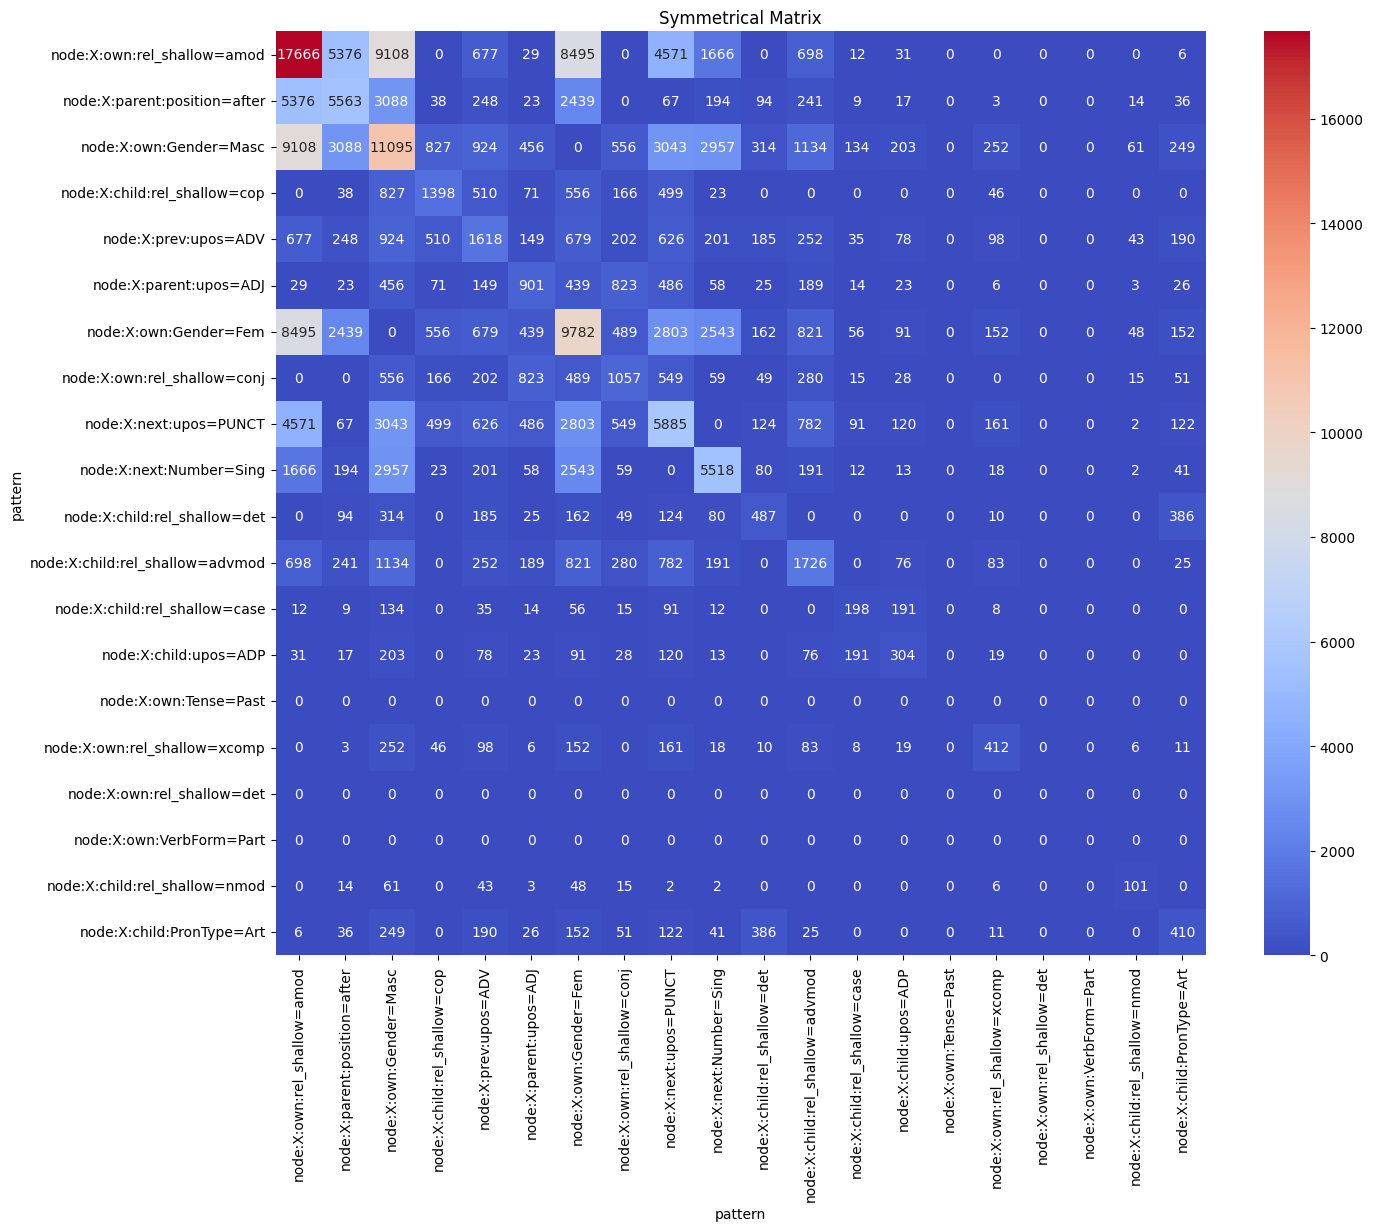

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
# Convert the values in the symmetrical matrix to integers
sym_matrix = sym_matrix.astype(int)
# Visualize the symmetrical matrix
plt.figure(figsize=(15, 12))  # Adjusted figsize for better visibility
sns.heatmap(sym_matrix, annot=True, fmt="d", cmap='coolwarm')  # fmt=".2g" for scientific notation
plt.title('Symmetrical Matrix')
plt.show()

In [60]:
# Create a new DataFrame to store the percentage values
percentage_df = pd.DataFrame(index=sym_matrix.index, columns=sym_matrix.columns)

# Fill the DataFrame with the percentage values
for row in sym_matrix.index:
    for col in sym_matrix.columns:
        if sym_matrix.loc[row, row] != 0:
            percentage_df.loc[row, col] = (sym_matrix.loc[row, col] / sym_matrix.loc[row, row]) * 100
        else:
            percentage_df.loc[row, col] = 0

# Print the percentage DataFrame
percentage_df

pattern,node:X:own:rel_shallow=amod,node:X:parent:position=after,node:X:own:Gender=Masc,node:X:child:rel_shallow=cop,node:X:prev:upos=ADV,node:X:parent:upos=ADJ,node:X:own:Gender=Fem,node:X:own:rel_shallow=conj,node:X:next:upos=PUNCT,node:X:next:Number=Sing,node:X:child:rel_shallow=det,node:X:child:rel_shallow=advmod,node:X:child:rel_shallow=case,node:X:child:upos=ADP,node:X:own:Tense=Past,node:X:own:rel_shallow=xcomp,node:X:own:rel_shallow=det,node:X:own:VerbForm=Part,node:X:child:rel_shallow=nmod,node:X:child:PronType=Art
pattern,,,,,,,,,,,,,,,,,,,,
node:X:own:rel_shallow=amod,100.0,30.431337,51.556663,0.0,3.83222,0.164157,48.08672,0.0,25.874561,9.430545,0.0,3.951092,0.067927,0.175478,0.0,0.0,0.0,0.0,0.0,0.033964
node:X:parent:position=after,96.638504,100.0,55.509617,0.683085,4.458026,0.413446,43.84325,0.0,1.204386,3.487327,1.689736,4.332195,0.161783,0.305591,0.0,0.053928,0.0,0.0,0.251663,0.647133
node:X:own:Gender=Masc,82.091032,27.832357,100.0,7.453808,8.328076,4.109959,0.0,5.011266,27.426769,26.651645,2.830104,10.22082,1.207751,1.829653,0.0,2.271293,0.0,0.0,0.549797,2.244254
node:X:child:rel_shallow=cop,0.0,2.718169,59.155937,100.0,36.480687,5.078684,39.771102,11.874106,35.693848,1.645207,0.0,0.0,0.0,0.0,0.0,3.290415,0.0,0.0,0.0,0.0
node:X:prev:upos=ADV,41.84178,15.327565,57.10754,31.520396,100.0,9.2089,41.965389,12.484549,38.68974,12.422744,11.433869,15.574784,2.163164,4.820766,0.0,6.05686,0.0,0.0,2.657602,11.742892
node:X:parent:upos=ADJ,3.218646,2.552719,50.610433,7.880133,16.537181,100.0,48.72364,91.342952,53.940067,6.437292,2.774695,20.976693,1.553829,2.552719,0.0,0.665927,0.0,0.0,0.332963,2.885683
node:X:own:Gender=Fem,86.843181,24.933551,0.0,5.683909,6.941321,4.487835,100.0,4.998978,28.654672,25.996729,1.656103,8.392967,0.57248,0.93028,0.0,1.553874,0.0,0.0,0.490697,1.553874
node:X:own:rel_shallow=conj,0.0,0.0,52.601703,15.704825,19.110691,77.861873,46.263009,100.0,51.939451,5.581835,4.635762,26.490066,1.419111,2.649007,0.0,0.0,0.0,0.0,1.419111,4.824976
node:X:next:upos=PUNCT,77.672048,1.138488,51.707732,8.479184,10.637213,8.258284,47.629567,9.328802,100.0,0.0,2.107052,13.28802,1.546304,2.039082,0.0,2.735769,0.0,0.0,0.033985,2.073067
